In [1]:
import os
import json
import numpy as np
from skimage import io as skio
import matplotlib.pyplot as plt
from skimage.measure import label

In [2]:
with open("../nucleus_meta.json", "r") as fj:
    config_json = json.load(fj)
raw_path = "/allen/aics/assay-dev/MicroscopyData/Ruian/2018/20181005/20181005_R01_003.czi"
seg_name = "/allen/aics/assay-dev/MicroscopyOtherData/Jianxu/Nucleus/segmentation/20181005_R01_003/shape/20181005_R01_003-Scene-01-P82-A02_seg_0.ome.tif"
series_id = int(seg_name.split("Scene")[1].split("-")[1]) - 1
print("series_id:", series_id)

series_id: 0


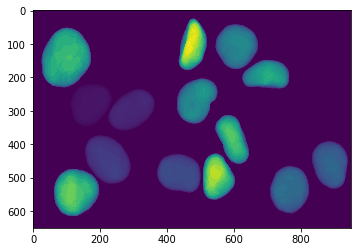

In [3]:
img_seg_all = skio.imread(seg_name)
img_seg_all[ 0,:,:] = 0
img_seg_all[-1,:,:] = 0
nz, ny, nx = img_seg_all.shape
plt.imshow(img_seg_all.mean(axis=0))

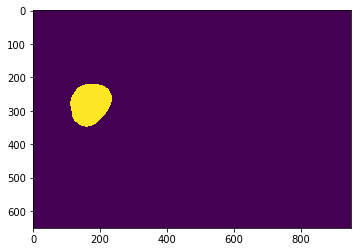

In [4]:
cell_id = 1
img_seg = img_seg_all.copy()
img_seg[img_seg!=cell_id] = 0
img_seg[img_seg==cell_id] = 1
plt.imshow(img_seg.max(axis=0))

In [5]:
print(img_seg.shape[0]*img_seg.shape[1]*img_seg.shape[2])
img_seg = label(img_seg)
print("#Comps:",np.unique(img_seg))
print("Sizes:",np.bincount(img_seg.flat,minlength=img_seg.max()))
largest_cc = 1 + np.argmax(np.bincount(img_seg.flat)[1:])
print("Largest CC:", largest_cc)

37050000
#Comps: [0 1]
Sizes: [36881096   168904]
Largest CC: 1


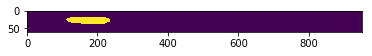

In [6]:
if img_seg.max() > 1:
    img_seg[img_seg!=largest_cc] = 0
    img_seg[img_seg>0] = 1
plt.imshow(img_seg.max(axis=0))
plt.imshow(img_seg.max(axis=1))

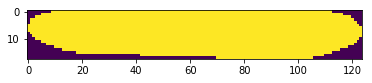

In [7]:
pxl_z, pxl_y, pxl_x = np.nonzero(img_seg)
img_seg_crop = img_seg[pxl_z.min():(pxl_z.max()+1),pxl_y.min():(pxl_y.max()+1),pxl_x.min():(pxl_x.max()+1)]
plt.imshow(img_seg_crop.max(axis=1))

(18, 128, 124) int64
(48, 128, 124)
int64 0 1


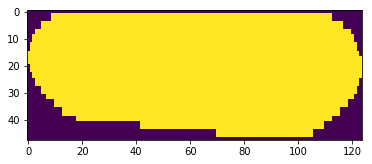

In [8]:
from skimage.transform import resize
nz_crop, ny_crop, nx_crop = img_seg_crop.shape
nz_crop_new = np.int((0.29/0.108)*nz_crop)
print(img_seg_crop.shape, img_seg_crop.dtype)
img_seg_crop_resize = resize(image=img_seg_crop, output_shape=(nz_crop_new,ny_crop,nx_crop), preserve_range=True, anti_aliasing=True, mode="constant")
img_seg_crop_resize = img_seg_crop_resize.astype(np.int64)
print(img_seg_crop_resize.shape)
plt.imshow(img_seg_crop_resize.max(axis=1))
print(img_seg_crop_resize.dtype,img_seg_crop_resize.min(),img_seg_crop_resize.max())

In [9]:
from aicsfeature.extractor import common
df_origin = common.get_shape_features(seg=img_seg_crop)
df_resize = common.get_shape_features(seg=img_seg_crop_resize)
print(df_origin,df_resize)

{'volume': 168904, 'surface_area': 16468, 'shape_1st_axis_x': 0.6501975368188253, 'shape_1st_axis_y': -0.7596773225241332, 'shape_1st_axis_z': 0.011555464391211813, 'shape_2nd_axis_x': -0.75973644866378, 'shape_2nd_axis_y': -0.6502300464696085, 'shape_2nd_axis_z': 0.001189638549543254, 'shape_3rd_axis_x': -0.006609968719987035, 'shape_3rd_axis_y': 0.009552607533857787, 'shape_3rd_axis_z': 0.9999325257250237, 'shape_1st_axis_length': 137.32837121357593, 'shape_2nd_axis_length': 113.12821809435269, 'shape_3rd_axis_length': 17.59175154662705, 'shape_1st_eigenvalue': 19.607927964538213, 'shape_2nd_eigenvalue': 680.6298171639454, 'shape_3rd_eigenvalue': 1050.4921806412985, 'shape_meridional_eccentricity': 0.9998257849805982, 'shape_equator_eccentricity': 0.999584948866064, 'shape_sphericity': 1.0621322605609722} {'volume': 415566, 'surface_area': 32854, 'shape_1st_axis_x': 0.6653268590473869, 'shape_1st_axis_y': -0.7456961112511977, 'shape_1st_axis_z': 0.035741856344909895, 'shape_2nd_axis_

In [10]:
import javabridge as jv, bioformats as bf
jv.start_vm(class_path=bf.JARS, max_heap_size='4G')

def get_stack_from_series_id(czi_path, channel, series_id, dim):

    # Extraction a series from multi-position CZI

    img_raw = []
    for slice in range(dim[0]):
        img_raw.append(bf.load_image(path=czi_path, series=series_id, c=channel, z=slice, t=0, rescale=False))
    img_raw = np.array(img_raw).reshape(*dim)

    return img_raw

In [11]:
img_raw = get_stack_from_series_id(czi_path=raw_path, channel=0, series_id=series_id, dim=(nz,ny,nx))

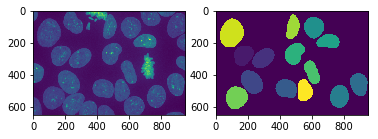

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(img_raw.max(axis=0))
ax[1].imshow(img_seg_all.max(axis=0))

(48, 128, 124)
int64 365 1946


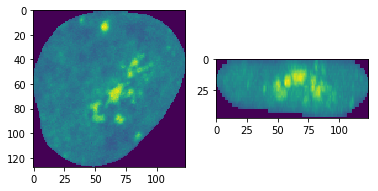

In [13]:
img_raw_crop = img_raw[pxl_z.min():(pxl_z.max()+1),pxl_y.min():(pxl_y.max()+1),pxl_x.min():(pxl_x.max()+1)]
img_raw_crop_resize = resize(image=img_raw_crop, output_shape=(nz_crop_new,ny_crop,nx_crop), preserve_range=True, anti_aliasing=True, mode="constant")
img_raw_crop_resize = img_raw_crop_resize.astype(np.int64)
print(img_raw_crop_resize.shape)
print(img_raw_crop_resize.dtype,img_raw_crop_resize.min(),img_raw_crop_resize.max())
img_input = (img_raw_crop_resize*img_seg_crop_resize)
fig, ax = plt.subplots(nrows=1,ncols=2)
img_input = np.clip(img_input, 422, 2149)
ax[0].imshow(img_input.max(axis=0))
ax[1].imshow(img_input.max(axis=1))

In [14]:
df = common.get_bright_spots_features(img=img_input)
df

== [11, 86, 68, 37, 59] (5, 23, 23)
== [11, 22, 36, 101, 91] (5, 23, 23)
== [11, 68, 66, 55, 61] (5, 23, 23)
== [11, 69, 88, 54, 39] (5, 23, 23)
== [11, 57, 14, 66, 113] (5, 23, 23)
== [11, 78, 67, 45, 60] (5, 23, 23)
== [11, 50, 79, 73, 48] (5, 23, 23)
== [11, 85, 102, 38, 25] (5, 23, 23)
== [11, 78, 52, 45, 75] (5, 23, 23)
== [11, 82, 43, 41, 84] (5, 23, 23)
== [11, 92, 56, 31, 71] (5, 23, 23)
== [11, 109, 31, 14, 96] (5, 23, 23)


{'bright_spots_number': 12,
 'bright_spots_intensity_mean': 1574.2142857142858,
 'bright_spots_width': 5.753256423910642}

In [15]:
from skimage.filters import gaussian
from skimage.morphology import extrema, binary_dilation

def norm_and_smooth(img_original):

    # Uses Jianxu's normalization and Gaussian smooth to
    # preprocess the input image. Parameters have default
    # values used in the segmentation toolkit.

    smooth_sigma = 1.0
    scaling_params = [0.5, 18]

    img_norm = img_original.copy()
    mean = img_norm.mean()
    stdv = img_norm.std()
    strech_min = np.max([mean-scaling_params[0]*stdv, img_norm.min()])
    strech_max = np.min([mean+scaling_params[1]*stdv, img_norm.max()])
    img_norm[img_norm > strech_max] = strech_max
    img_norm[img_norm < strech_min] = strech_min
    img_norm = (img_norm-strech_min + 1e-8)/(strech_max-strech_min + 1e-8)
    img_norm = gaussian(image=img_norm, sigma=smooth_sigma)

    # img_norm may contain negative values

    return img_norm

img_norm = norm_and_smooth(img_original=img_input)

# Find maxima

img_max = extrema.h_maxima(img_norm, h=0.1)
z_pxl, y_pxl, x_pxl = np.nonzero(img_max)

len(z_pxl)

14

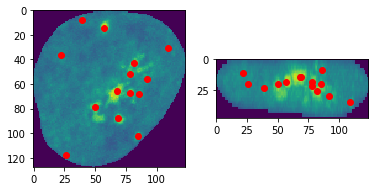

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(img_input.max(axis=0))
ax[0].plot(x_pxl,y_pxl,"ro")
ax[1].imshow(img_input.max(axis=1))
ax[1].plot(x_pxl,z_pxl,"ro")